Построение модели мультиклассовой классификации для распознания эмоций. Исходный датасет был скачан по этой ссылке https://www.kaggle.com/datasets/msambare/fer2013. В директории train/disgust было всего 436 изображений, поэтому я дополнил ее и папку test/disgust содержими из этого датасета https://www.kaggle.com/datasets/swish9/augmented-disgust-images-for-facial-emotions/data разделенным в пропорции 80/20 соответственно. 

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

def count_images(directory):
    counts = {}
    for emotion in os.listdir(directory):
        emotion_dir = os.path.join(directory, emotion)
        if os.path.isdir(emotion_dir):
            counts[emotion] = len(os.listdir(emotion_dir))
    return counts

train_counts = count_images("train")
test_counts = count_images("test")

print("Train:", train_counts)
print("Test:", test_counts)

Train: {'happy': 7215, 'sad': 4830, 'fear': 4097, 'surprise': 3171, 'neutral': 4965, 'angry': 3995, 'disgust': 1870}
Test: {'happy': 1774, 'sad': 1247, 'fear': 1024, 'surprise': 831, 'neutral': 1233, 'angry': 958, 'disgust': 637}


Однако даже в измененном датасете видно, что распределение классов неравномерное как в обучающей, так и в тестовой выборке. Класс happy доминирует (7215 примеров в train и 1774 в test), что почти в 4 раза больше, чем наименьший класс disgust (1870 в train и 637 в test). Такая диспропорция может привести к тому, что модель будет хуже распознавать редкие эмоции (disgust, surprise, angry) из-за перекоса в обучении в сторону более частых классов (happy, sad, neutral).

Для улучшения результатов будем применять методы борьбы с дисбалансом: аугментацию данных для классов с недостающими данными (disgust, surprise).

Провизуализируем некоторые данные, каксающиеся датасета

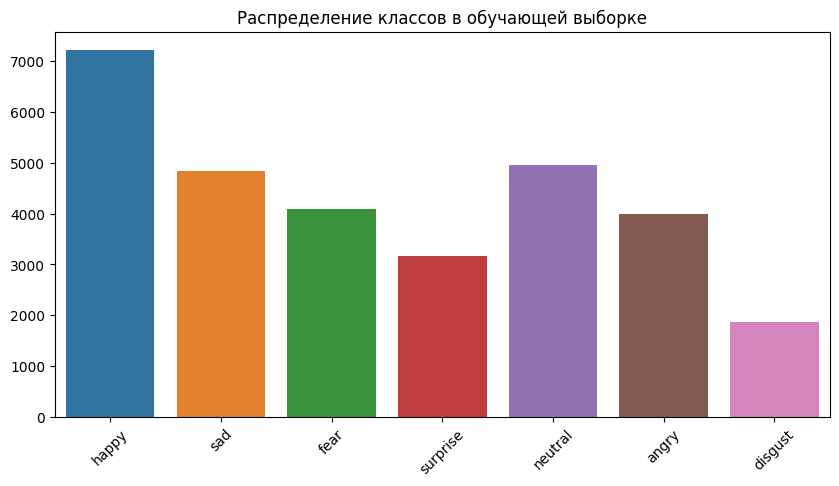

In [3]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Распределение классов в обучающей выборке")
plt.xticks(rotation=45)
plt.show()

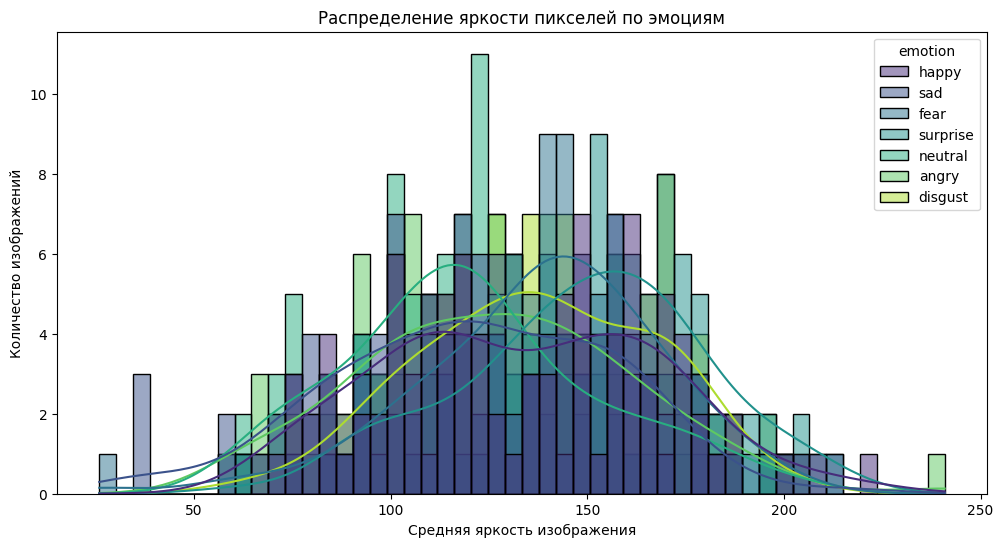

In [4]:
import numpy as np

# Создаем пустой DataFrame
pixels_df = pd.DataFrame(columns=["brightness", "emotion"])

for emotion in os.listdir("train"):
    emotion_dir = os.path.join("train", emotion)
    
    # Пропускаем не-директории
    if not os.path.isdir(emotion_dir):
        continue

    image_files = [f for f in os.listdir(emotion_dir) 
                  if f.endswith(('.jpg', '.png', '.jpeg')) and not f.startswith('.')][:100]
    
    for img_file in image_files:
        img_path = os.path.join(emotion_dir, img_file)
        img = np.array(Image.open(img_path))
        brightness = img.mean()  # Средняя яркость изображения
        pixels_df = pd.concat([pixels_df, pd.DataFrame({"brightness": [brightness], "emotion": [emotion]})], 
                            ignore_index=True)

# Строим график
plt.figure(figsize=(12, 6))
sns.histplot(data=pixels_df, x="brightness", hue="emotion", bins=50, kde=True, palette="viridis")
plt.title("Распределение яркости пикселей по эмоциям")
plt.xlabel("Средняя яркость изображения")
plt.ylabel("Количество изображений")
plt.show()

Эмоции типа "happy" и "surprise" демонстрируют более высокую среднюю яркость, что может быть связано с открытыми глазами и широкими улыбками

Эмоции "sad" и "angry" имеют более низкую яркость, вероятно, из-за затемненных участков лица (нахмуренные брови, опущенные веки)

Заметное перекрытие гистограмм для эмоций "fear" и "neutral" указывает на потенциальную сложность их различения по яркости

Класс "disgust" имеет широкий разброс яркости, что может свидетельствовать о разнообразии проявлений этой эмоции

Вывод: Яркость как единственный признак может быть недостаточен для точной классификации.

Для определения наиболее полезных признаков модели проведем feature importance.

HOG (Histogram of Oriented Gradients) - признак, описывающий контуры и направление градиентов яркости на изображении. Число рядом с названием признака означает омер ячейки в гистограмме (указывает на конкретную зону лица: рот, брови и т.д.).

LBP (Local Binary Patterns) - признак, анализирующий текстуру кожи (например, морщины, гладкость).

F-score - метрика, показывающая, насколько хорошо признак разделяет классы эмоций (чем выше, тем важнее признак)

p-value - вероятность, что связь признака с эмоцией случайна.

Успешно обработано: 700 изображений
Не удалось обработать: 0 изображений

Топ-10 наиболее значимых признаков:
       Feature    F_score       p_value
77       LBP_5  26.912729  6.693700e-29
72       LBP_0  25.220328  3.796414e-27
81       LBP_9  21.826608  1.414071e-23
73       LBP_1  12.277282  3.710188e-13
76       LBP_4  12.049234  6.666800e-13
79       LBP_7  11.762057  1.395409e-12
22      HOG_22  11.100239  7.673774e-12
82  Brightness   9.829706  2.038852e-10
75       LBP_3   8.987198  1.799580e-09
53      HOG_53   8.458459  7.058571e-09


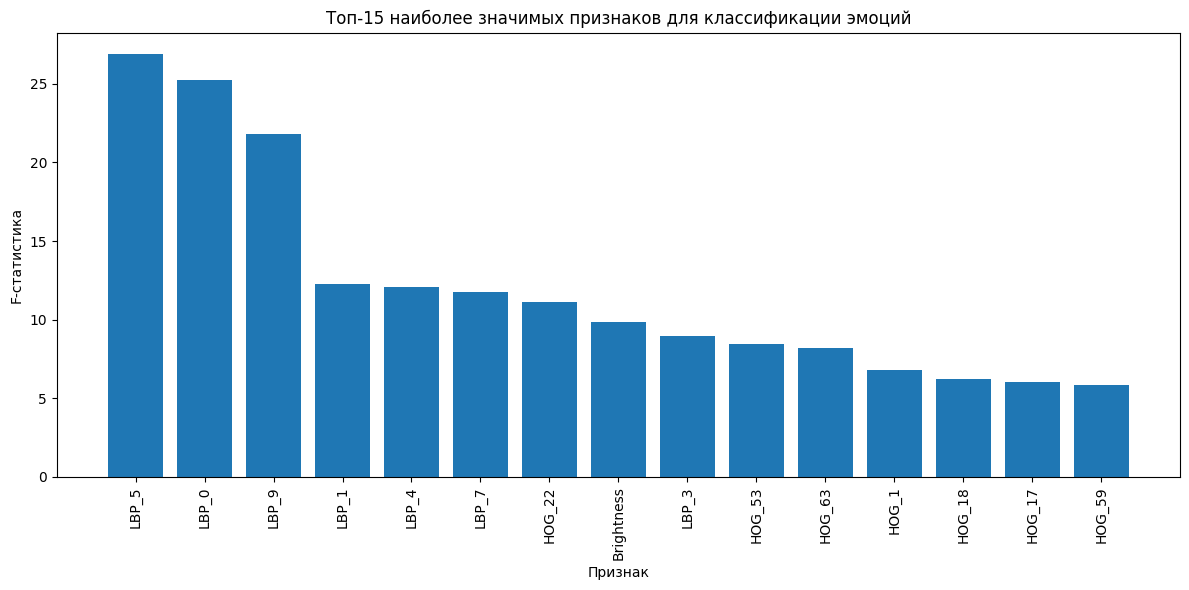

In [5]:
from skimage.feature import hog, local_binary_pattern
from sklearn.feature_selection import f_classif
from PIL import Image

# Конфигурация HOG
HOG_ORIENTATIONS = 8
HOG_PIXELS_PER_CELL = (16, 16)
HOG_CELLS_PER_BLOCK = (1, 1)
LBP_POINTS = 8
LBP_RADIUS = 1
LBP_BINS = 10

def extract_features(image_path):
    """Извлекает HOG, LBP и яркость из изображения"""
    try:
        img = Image.open(image_path).convert('L')  # Конвертируем в grayscale
        img = np.array(img)
        
        # Извлекаем HOG признаки
        hog_features = hog(img, 
                          orientations=HOG_ORIENTATIONS,
                          pixels_per_cell=HOG_PIXELS_PER_CELL,
                          cells_per_block=HOG_CELLS_PER_BLOCK,
                          visualize=False)
        
        # Извлекаем LBP признаки
        lbp = local_binary_pattern(img, 
                                  P=LBP_POINTS, 
                                  R=LBP_RADIUS, 
                                  method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=LBP_BINS, range=(0, LBP_BINS))
        
        # Средняя яркость
        brightness = img.mean()
        
        # Объединяем все признаки
        return np.concatenate([hog_features, lbp_hist, [brightness]])
    
    except Exception as e:
        print(f"Ошибка при обработке {image_path}: {str(e)}")
        return None

# Собираем все данные
X = []
y = []
failed_images = 0

for emotion in os.listdir("train"):
    emotion_dir = os.path.join("train", emotion)
    if not os.path.isdir(emotion_dir):
        continue
        
    for img_file in os.listdir(emotion_dir)[:100]:  # Ограничиваем выборку для скорости
        if not img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
            
        img_path = os.path.join(emotion_dir, img_file)
        features = extract_features(img_path)
        
        if features is not None:
            X.append(features)
            y.append(emotion)
        else:
            failed_images += 1

print(f"Успешно обработано: {len(X)} изображений")
print(f"Не удалось обработать: {failed_images} изображений")

# Преобразуем в numpy массивы
X = np.array(X)
y = np.array(y)

# Вычисляем количество HOG признаков (для именования)
hog_len = len(hog(np.zeros((48, 48)),
                orientations=HOG_ORIENTATIONS,
                pixels_per_cell=HOG_PIXELS_PER_CELL,
                cells_per_block=HOG_CELLS_PER_BLOCK,
                visualize=False))

# Создаем имена признаков
feature_names = [f"HOG_{i}" for i in range(hog_len)] + \
               [f"LBP_{i}" for i in range(LBP_BINS)] + \
               ["Brightness"]

# Анализ значимости признаков
f_scores, p_values = f_classif(X, y)

# Создаем DataFrame с результатами
feature_importance = pd.DataFrame({
    "Feature": feature_names,
    "F_score": f_scores,
    "p_value": p_values
}).sort_values("F_score", ascending=False)

# Выводим топ-10 наиболее значимых признаков
print("\nТоп-10 наиболее значимых признаков:")
print(feature_importance.head(10))

# Визуализация
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['Feature'][:15], feature_importance['F_score'][:15])
plt.title("Топ-15 наиболее значимых признаков для классификации эмоций")
plt.xlabel("Признак")
plt.ylabel("F-статистика")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Наиболее значимыми признаками для классификации являются показатели текстуры лица LBP_5, LBP_0, LBP_9. Сфокисуремся на этих признаках и в дальнейшем будем делать на них акцент

HOG_22(F=11.1) и ярксоть(F=9.8) менее значимы, но тоже важны.

Все топ-признаки имеют крайне низкие p-значения (< 1e-09), что подтверждает их статистическую значимость.

Обучим первую простую нейросеть при помощи sequintal из библиотеки keras

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 35s 87ms/step - accuracy: 0.2448 - loss: 1.8632 - precision: 0.3887 - recall: 0.0069 - val_accuracy: 0.3611 - val_loss: 1.6613 - val_precision: 0.7830 - val_recall: 0.0413
Epoch 2/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.3571 - loss: 1.6553 - precision: 0.6889 - recall: 0.0912 - val_accuracy: 0.4176 - val_loss: 1.5185 - val_precision: 0.7188 - val_recall: 0.1602
Epoch 3/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 32s 86ms/step - accuracy: 0.4141 - loss: 1.5360 - precision: 0.7206 - recall: 0.1496 - val_accuracy: 0.4417 - val_loss: 1.4537 - val_precision: 0.7669 - val_recall: 0.1730
Epoch 4/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 34s 90ms/step - accuracy: 0.4365 - loss: 1.4795 - precision: 0.7348 - recall: 0.1745 - val_accuracy: 0.4546 - val_loss: 1.4456 - val_precision: 0.7794 - val_recall: 0.1705
Epoch 5/20
377/377 ━━━━━━━━━━━━━━━━━━━━ 33s 87ms/step - accuracy: 0.4622 - loss: 1.4204 - precision: 0.7531 - recall: 0.2043 - val_accuracy: 0.4666 - va

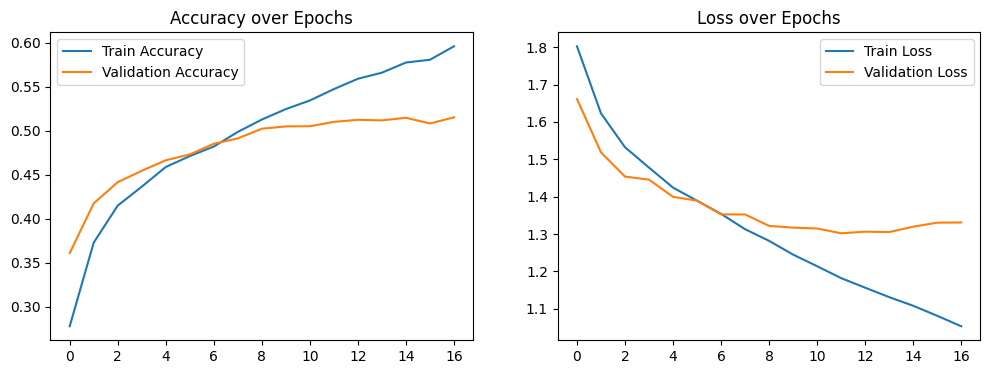

189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.46      0.30      0.36       850
     disgust       0.67      0.55      0.60       346
        fear       0.40      0.21      0.28       822
       happy       0.65      0.77      0.70      1415
     neutral       0.50      0.47      0.48      1010
         sad       0.34      0.53      0.42       997
    surprise       0.65      0.61      0.63       589

    accuracy                           0.51      6029
   macro avg       0.52      0.49      0.50      6029
weighted avg       0.51      0.51      0.50      6029


Confusion Matrix:


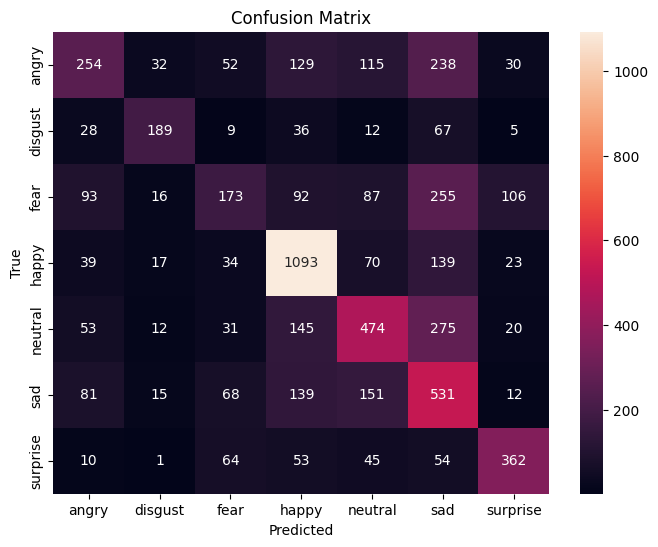

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Загрузка и подготовка данных
def load_data(data_dir, img_size=(48, 48)):
    images = []
    labels = []
    
    for emotion in os.listdir(data_dir):
        emotion_dir = os.path.join(data_dir, emotion)
        if not os.path.isdir(emotion_dir):
            continue
            
        for img_file in os.listdir(emotion_dir):
            if img_file.startswith('.'):
                continue
                
            img_path = os.path.join(emotion_dir, img_file)
            try:
                img = Image.open(img_path).convert('L')  # Grayscale
                img = img.resize(img_size)
                img_array = np.array(img) / 255.0  # Нормализация
                images.append(img_array)
                labels.append(emotion)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Загрузка данных
X, y = load_data("train")

# Преобразование меток
le = LabelEncoder()
y_int = le.fit_transform(y)
y_categorical = to_categorical(y_int)

# Разделение данных
X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Добавление размерности канала (для CNN)
X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))

# Создание модели
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

# Компиляция модели
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

# Колбэк для ранней остановки
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Обучение модели
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

# Визуализация обучения
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Оценка модели
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Вывод метрик
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

print("\nConfusion Matrix:")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion Matrix показывает, как часто модель путает эмоции. Идеальная матрица была бы диагональной.

Проанализируем результаты:
"Fear" часто путают с "sad" (255 ошибок) и "angry" (93 ошибки).
"Disgust" лучше распознаётся (189 верных предсказаний), но иногда путается с "angry" (28 ошибок).
"Happy" имеет больше всего верных предсказаний (1093), но 139 раз ошибочно классифицируется как "sad".
 
Classification Report основные метрики:
    Precision (Точность): Доля верно предсказанных случаев среди всех предсказаний класса.
Например, для "happy" — 65% (из всех предсказанных "happy" 65% верны).
    Recall (Полнота): Доль верно найденных случаев среди всех реальных случаев класса.
Например, для "happy" — 77% (модель нашла 77% всех реальных "happy").
    F1-score: Среднее гармоническое precision и recall.
Наивысший F1 у "happy" (0.70) и "surprise" (0.63).

Тревожные сигналы:
    Низкий recall для "fear" (0.21): модель пропускает 79% случаев страха.
    Низкий precision для "sad" (0.34): 66% предсказанных "sad" — ошибки.

Выводы.
Хорошо распознаются: "Happy" (F1=0.70) и "surprise" (F1=0.63) — лучшие результаты. "Disgust" (F1=0.60) — приемлемо, но есть куда расти.
Проблемные классы: "Fear" и "angry" часто путаются между собой и с "sad". "Sad" имеет низкую точность (много ложных срабатываний).
Общая точность (accuracy) — 51%, что ниже желаемого.

Попробуем отбалансировать датасет. Выполним аугментацию классов, в которых недостает содержимого, при помощи библиотеки Albumentations. Она представляет возможность автоматического расчета, сколько нужно новых изображений для каждого класса.

Применяемые транфсормации:
- Горизонтальное отражение
- Повороты до 15 градусов
- Изменение яркости/контраста
- Эластичные деформации

In [19]:
import albumentations as A
from tqdm import tqdm
from collections import defaultdict

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.4),
    A.Rotate(limit=12, p=0.6),
    A.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.4),
    A.CoarseDropout(max_holes=3, max_height=12, max_width=12, p=0.2),
])

def smart_augment_class(class_dir, target_count, output_dir):
    existing_files = [f for f in os.listdir(class_dir) 
                    if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    current_count = len(existing_files)
    
    if current_count >= target_count:
        # Если уже достаточно, просто копируем
        os.makedirs(output_dir, exist_ok=True)
        for f in existing_files:
            src = os.path.join(class_dir, f)
            dst = os.path.join(output_dir, f)
            if not os.path.exists(dst):
                Image.open(src).save(dst)
        return
    
    # Загружаем все изображения
    images = []
    for f in existing_files:
        img = Image.open(os.path.join(class_dir, f)).convert('RGB')
        images.append(np.array(img))
    
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Сначала копируем оригиналы
    for i, img in enumerate(images):
        dst_path = os.path.join(output_dir, f"orig_{i}.jpg")
        Image.fromarray(img).save(dst_path)
    
    # 2. Вычисляем сколько нужно добавить
    remaining = target_count - current_count
    augmented_per_image = max(1, (remaining // current_count) + 1)
    
    # 3. Создаем аугментированные версии
    created = 0
    with tqdm(total=remaining, desc=f'Augmenting {os.path.basename(class_dir)}') as pbar:
        while created < remaining:
            for i, img in enumerate(images):
                if created >= remaining:
                    break
                
                augmented = augmentation_pipeline(image=img)['image']
                dst_path = os.path.join(output_dir, f"aug_{created}.jpg")
                Image.fromarray(augmented).save(dst_path)
                created += 1
                pbar.update(1)


train_dir = 'train'
augmented_dir = 'train_augmented'
TARGET_COUNT = 7215

# Создаем сбалансированный датасет
all_classes = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

for class_name in all_classes:
    class_path = os.path.join(train_dir, class_name)
    output_path = os.path.join(augmented_dir, class_name)
    
    print(f"\nОбработка класса: {class_name}")
    smart_augment_class(class_path, TARGET_COUNT, output_path)

for class_name in all_classes:
    count = len(os.listdir(os.path.join(augmented_dir, class_name)))
    print(f"{class_name}: {count} изображений")

print(f"\nВсе классы доведены до {TARGET_COUNT} изображений. Данные сохранены в: {augmented_dir}")

/var/folders/t2/c2p6s0fd6yx6yqc5b42tdwvh0000gn/T/ipykernel_37703/1830192515.py:9: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=12, max_width=12, p=0.2),



Обработка класса: happy

Обработка класса: sad


Augmenting sad: 100%|██████████| 2385/2385 [00:01<00:00, 1399.78it/s]



Обработка класса: fear


Augmenting fear: 100%|██████████| 3118/3118 [00:02<00:00, 1351.96it/s]



Обработка класса: surprise


Augmenting surprise: 100%|██████████| 4044/4044 [00:02<00:00, 1397.58it/s]



Обработка класса: neutral


Augmenting neutral: 100%|██████████| 2250/2250 [00:01<00:00, 1412.70it/s]



Обработка класса: angry


Augmenting angry: 100%|██████████| 3220/3220 [00:02<00:00, 1394.66it/s]



Обработка класса: disgust


Augmenting disgust: 100%|██████████| 5345/5345 [00:03<00:00, 1400.31it/s]

happy: 7215 изображений
sad: 7215 изображений
fear: 7215 изображений
surprise: 7215 изображений
neutral: 7215 изображений
angry: 7215 изображений
disgust: 7215 изображений

Все классы доведены до 7215 изображений. Данные сохранены в: train_augmented


In [89]:
train_dir = 'test'
augmented_dir = 'test_augmented'
TARGET_COUNT = 2000

# Создаем сбалансированный датасет
all_classes = ['happy', 'sad', 'fear', 'surprise', 'neutral', 'angry', 'disgust']

for class_name in all_classes:
    class_path = os.path.join(train_dir, class_name)
    output_path = os.path.join(augmented_dir, class_name)
    
    print(f"\nОбработка класса: {class_name}")
    smart_augment_class(class_path, TARGET_COUNT, output_path)

for class_name in all_classes:
    count = len(os.listdir(os.path.join(augmented_dir, class_name)))
    print(f"{class_name}: {count} изображений")

print(f"\nВсе классы доведены до {TARGET_COUNT} изображений. Данные сохранены в: {augmented_dir}")


Обработка класса: happy


Augmenting happy: 100%|██████████| 226/226 [00:00<00:00, 826.90it/s]



Обработка класса: sad


Augmenting sad: 100%|██████████| 753/753 [00:00<00:00, 1219.55it/s]



Обработка класса: fear


Augmenting fear: 100%|██████████| 976/976 [00:00<00:00, 1293.05it/s]



Обработка класса: surprise


Augmenting surprise: 100%|██████████| 1169/1169 [00:00<00:00, 1448.18it/s]



Обработка класса: neutral


Augmenting neutral: 100%|██████████| 767/767 [00:00<00:00, 923.32it/s] 



Обработка класса: angry


Augmenting angry: 100%|██████████| 1042/1042 [00:00<00:00, 1169.18it/s]



Обработка класса: disgust


Augmenting disgust: 100%|██████████| 1363/1363 [00:00<00:00, 1444.92it/s]

happy: 2000 изображений
sad: 2000 изображений
fear: 2000 изображений
surprise: 2000 изображений
neutral: 2000 изображений
angry: 2000 изображений
disgust: 2000 изображений

Все классы доведены до 2000 изображений. Данные сохранены в: test_augmented


In [20]:
train_counts = count_images("train_augmented")
print("Train:", train_counts)

Train: {'happy': 7215, 'sad': 7215, 'fear': 7215, 'surprise': 7215, 'neutral': 7215, 'angry': 7215, 'disgust': 7215}


Повторно обучаем модель на аугментированном датасете

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 3822s 3s/step - accuracy: 0.2625 - loss: 1.8320 - precision: 0.5787 - recall: 0.0274 - val_accuracy: 0.4239 - val_loss: 1.5250 - val_precision: 0.7420 - val_recall: 0.1706
Epoch 2/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 2123s 3s/step - accuracy: 0.4215 - loss: 1.5296 - precision: 0.7370 - recall: 0.1622 - val_accuracy: 0.4604 - val_loss: 1.4145 - val_precision: 0.7837 - val_recall: 0.2113
Epoch 3/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1319s 2s/step - accuracy: 0.4583 - loss: 1.4334 - precision: 0.7464 - recall: 0.2094 - val_accuracy: 0.4886 - val_loss: 1.3538 - val_precision: 0.7834 - val_recall: 0.2284
Epoch 4/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - accuracy: 0.4832 - loss: 1.3677 - precision: 0.7492 - recall: 0.2391 - val_accuracy: 0.4764 - val_loss: 1.3592 - val_precision: 0.7932 - val_recall: 0.2278
Epoch 5/50
632/632 ━━━━━━━━━━━━━━━━━━━━ 2143s 3s/step - accuracy: 0.4988 - loss: 1.3222 - precision: 0.7675 - recall: 0.2693 - val_accuracy: 0.5188 - va

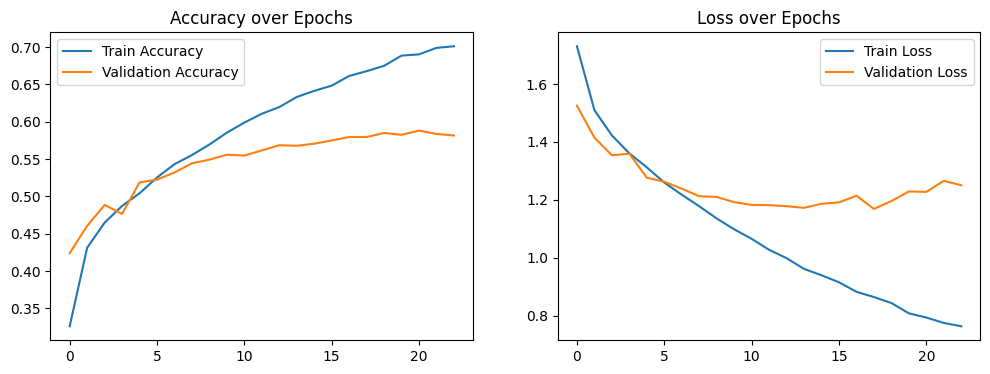

316/316 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step

Classification Report:
              precision    recall  f1-score   support

       angry       0.48      0.45      0.47      1394
     disgust       0.81      0.84      0.83      1439
        fear       0.44      0.35      0.39      1451
       happy       0.76      0.66      0.70      1495
     neutral       0.49      0.51      0.50      1476
         sad       0.37      0.49      0.42      1419
    surprise       0.75      0.75      0.75      1427

    accuracy                           0.58     10101
   macro avg       0.59      0.58      0.58     10101
weighted avg       0.59      0.58      0.58     10101


Confusion Matrix:


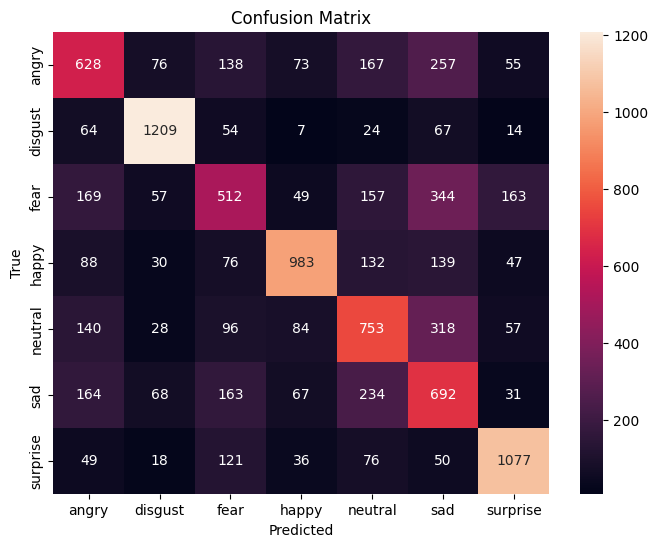

In [ ]:
X, y = load_data("train_augmented")

le = LabelEncoder()
y_int = le.fit_transform(y)
y_categorical = to_categorical(y_int)

X_train, X_val, y_train, y_val = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

X_train = X_train.reshape(X_train.shape + (1,))
X_val = X_val.reshape(X_val.shape + (1,))

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall')])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

print("\nConfusion Matrix:")
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), 
            annot=True, fmt='d', 
            xticklabels=le.classes_, 
            yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

После аугментации датасета тестовая точность модели выросла с 0.6 до 0.7. При этом сама модель также страдает от переобучения, линии Train Accuracy и Validation Accuracy начинают расходиться после 5 эпохи и val_accuracy составляет около 58%. Эмоции neutral, fear и anrgy чаще всего путают с sad. 

Попробуем обучить VGG16 - предобученную сверточную нейронную сеть для выделения признаков изображений

Found 50505 images belonging to 7 classes.
Found 7704 images belonging to 7 classes.
Epoch 1/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.2280 - loss: 1.9297

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 305s 192ms/step - accuracy: 0.2281 - loss: 1.9296 - val_accuracy: 0.3557 - val_loss: 1.6859
Epoch 2/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 5:14 200ms/step - accuracy: 0.3438 - loss: 1.6501

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1578/1578 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.3438 - loss: 1.6501 - val_accuracy: 0.3562 - val_loss: 1.6857
Epoch 3/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3462 - loss: 1.6924

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 301s 191ms/step - accuracy: 0.3462 - loss: 1.6923 - val_accuracy: 0.3814 - val_loss: 1.6303
Epoch 4/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 4:11 159ms/step - accuracy: 0.4062 - loss: 1.5326

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.4062 - loss: 1.5326 - val_accuracy: 0.3826 - val_loss: 1.6298
Epoch 5/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.3665 - loss: 1.6440

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 295s 187ms/step - accuracy: 0.3666 - loss: 1.6440 - val_accuracy: 0.3913 - val_loss: 1.5992
Epoch 6/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3750 - loss: 1.5996 - val_accuracy: 0.3910 - val_loss: 1.5993
Epoch 7/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3818 - loss: 1.6119

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 293s 186ms/step - accuracy: 0.3818 - loss: 1.6119 - val_accuracy: 0.3944 - val_loss: 1.5934
Epoch 8/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 4:26 169ms/step - accuracy: 0.4688 - loss: 1.4546

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accuracy: 0.4688 - loss: 1.4546 - val_accuracy: 0.3945 - val_loss: 1.5938
Epoch 9/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - accuracy: 0.3927 - loss: 1.5832

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 306s 194ms/step - accuracy: 0.3927 - loss: 1.5832 - val_accuracy: 0.4053 - val_loss: 1.5697
Epoch 10/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 4:22 167ms/step - accuracy: 0.3438 - loss: 1.5460

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3438 - loss: 1.5460 - val_accuracy: 0.4057 - val_loss: 1.5692
Epoch 11/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.4047 - loss: 1.5644

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 299s 189ms/step - accuracy: 0.4047 - loss: 1.5644 - val_accuracy: 0.4082 - val_loss: 1.5566
Epoch 12/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 4:15 162ms/step - accuracy: 0.2812 - loss: 1.6374

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.2812 - loss: 1.6374 - val_accuracy: 0.4090 - val_loss: 1.5567
Epoch 13/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4100 - loss: 1.5466

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 286s 181ms/step - accuracy: 0.4100 - loss: 1.5466 - val_accuracy: 0.4142 - val_loss: 1.5462
Epoch 14/20
   1/1578 ━━━━━━━━━━━━━━━━━━━━ 4:23 167ms/step - accuracy: 0.3125 - loss: 1.6552

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.3125 - loss: 1.6552 - val_accuracy: 0.4146 - val_loss: 1.5465
Epoch 15/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4177 - loss: 1.5308

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 304s 193ms/step - accuracy: 0.4177 - loss: 1.5308 - val_accuracy: 0.4229 - val_loss: 1.5315
Epoch 16/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.3750 - loss: 1.6005 - val_accuracy: 0.4229 - val_loss: 1.5313
Epoch 17/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 295s 187ms/step - accuracy: 0.4229 - loss: 1.5247 - val_accuracy: 0.4224 - val_loss: 1.5273
Epoch 18/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 37s 23ms/step - accuracy: 0.6562 - loss: 1.3290 - val_accuracy: 0.4217 - val_loss: 1.5275
Epoch 19/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.4283 - loss: 1.5042

1578/1578 ━━━━━━━━━━━━━━━━━━━━ 289s 183ms/step - accuracy: 0.4283 - loss: 1.5042 - val_accuracy: 0.4289 - val_loss: 1.5116
Epoch 20/20
1578/1578 ━━━━━━━━━━━━━━━━━━━━ 39s 25ms/step - accuracy: 0.3438 - loss: 1.7524 - val_accuracy: 0.4286 - val_loss: 1.5118


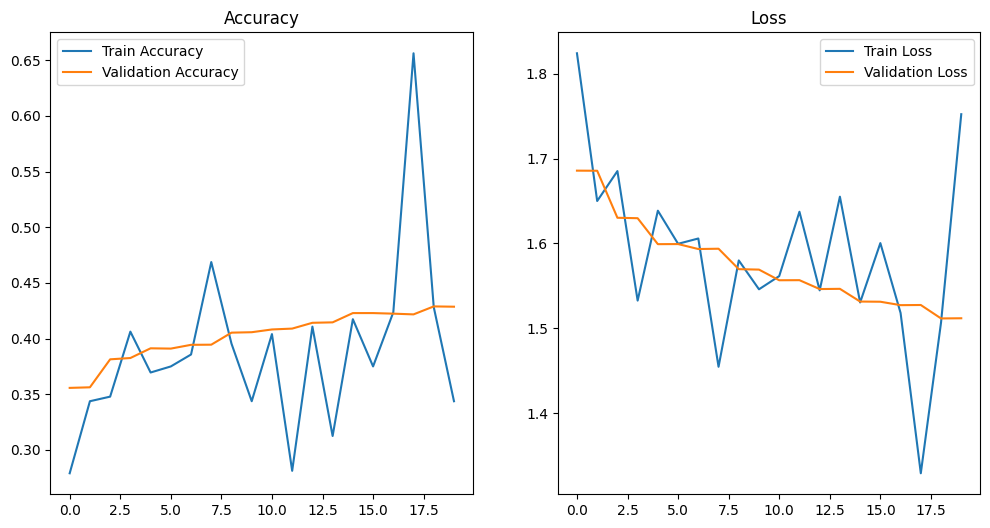

241/241 ━━━━━━━━━━━━━━━━━━━━ 39s 162ms/step - accuracy: 0.3763 - loss: 1.5779
Test accuracy: 0.4293


In [ ]:
from tensorflow.keras.applications import VGG16

train_dir = 'train_augmented'
test_dir = 'test'

# Параметры
IMG_SIZE = (48, 48) 
BATCH_SIZE = 32
EPOCHS = 20
NUM_CLASSES = 7

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
#Нормализация
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Загрузка данных
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

base_model = VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Замораживаем слои базовой модели
for layer in base_model.layers:
    layer.trainable = False

# Добавляем свои слои поверх базовой модели
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Создаем модель для обучения
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция модели
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Коллбэки
checkpoint = ModelCheckpoint(
    'emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

# Обучение модели
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop]
)

# Визуализация результатов
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.savefig('training_history.png')
plt.show()

# Оценка модели на тестовых данных
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc:.4f}')

Нейросеть дообучалась почти час, а результаты крайне плохи. Тестовая точность 0.4293, что гораздо хуже у простой обученной нейронной сети. Значение точности в процессе обучения сильно скачет. 

Попробуем обучить на основе другой модели классфиикации изображений MobileNetV2.

Found 50505 images belonging to 7 classes.
Found 7704 images belonging to 7 classes.


/var/folders/t2/c2p6s0fd6yx6yqc5b42tdwvh0000gn/T/ipykernel_37703/417768076.py:33: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


Epoch 1/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2354 - loss: 2.2227

789/789 ━━━━━━━━━━━━━━━━━━━━ 105s 125ms/step - accuracy: 0.2354 - loss: 2.2225 - val_accuracy: 0.3535 - val_loss: 1.7273 - learning_rate: 1.0000e-04
Epoch 2/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.2812 - loss: 2.0513 - val_accuracy: 0.3527 - val_loss: 1.7273 - learning_rate: 1.0000e-04
Epoch 3/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3477 - loss: 1.7627

789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 105ms/step - accuracy: 0.3477 - loss: 1.7626 - val_accuracy: 0.3805 - val_loss: 1.6433 - learning_rate: 1.0000e-04
Epoch 4/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4531 - loss: 1.6626 - val_accuracy: 0.3802 - val_loss: 1.6437 - learning_rate: 1.0000e-04
Epoch 5/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3824 - loss: 1.6383

789/789 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step - accuracy: 0.3824 - loss: 1.6383 - val_accuracy: 0.3924 - val_loss: 1.6049 - learning_rate: 1.0000e-04
Epoch 6/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.3594 - loss: 1.7298 - val_accuracy: 0.3918 - val_loss: 1.6048 - learning_rate: 1.0000e-04
Epoch 7/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4117 - loss: 1.5481

789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.4117 - loss: 1.5481 - val_accuracy: 0.4017 - val_loss: 1.5853 - learning_rate: 1.0000e-04
Epoch 8/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:17 98ms/step - accuracy: 0.3906 - loss: 1.4978

789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.3906 - loss: 1.4978 - val_accuracy: 0.4023 - val_loss: 1.5854 - learning_rate: 1.0000e-04
Epoch 9/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4336 - loss: 1.4946

789/789 ━━━━━━━━━━━━━━━━━━━━ 83s 106ms/step - accuracy: 0.4336 - loss: 1.4946 - val_accuracy: 0.4085 - val_loss: 1.5718 - learning_rate: 1.0000e-04
Epoch 10/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4219 - loss: 1.4888 - val_accuracy: 0.4085 - val_loss: 1.5720 - learning_rate: 1.0000e-04
Epoch 11/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.4524 - loss: 1.4571 - val_accuracy: 0.4083 - val_loss: 1.5673 - learning_rate: 1.0000e-04
Epoch 12/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:05 83ms/step - accuracy: 0.5469 - loss: 1.4681

789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.5469 - loss: 1.4681 - val_accuracy: 0.4086 - val_loss: 1.5672 - learning_rate: 1.0000e-04
Epoch 13/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4732 - loss: 1.4043

789/789 ━━━━━━━━━━━━━━━━━━━━ 80s 101ms/step - accuracy: 0.4732 - loss: 1.4043 - val_accuracy: 0.4089 - val_loss: 1.5590 - learning_rate: 1.0000e-04
Epoch 14/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:04 82ms/step - accuracy: 0.4375 - loss: 1.5256

789/789 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.4375 - loss: 1.5256 - val_accuracy: 0.4090 - val_loss: 1.5592 - learning_rate: 1.0000e-04
Epoch 15/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.4838 - loss: 1.3828

789/789 ━━━━━━━━━━━━━━━━━━━━ 87s 110ms/step - accuracy: 0.4838 - loss: 1.3828 - val_accuracy: 0.4132 - val_loss: 1.5568 - learning_rate: 1.0000e-04
Epoch 16/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:12 93ms/step - accuracy: 0.4688 - loss: 1.4658

789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.4688 - loss: 1.4658 - val_accuracy: 0.4137 - val_loss: 1.5569 - learning_rate: 1.0000e-04
Epoch 17/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 81s 103ms/step - accuracy: 0.4944 - loss: 1.3508 - val_accuracy: 0.4134 - val_loss: 1.5544 - learning_rate: 1.0000e-04
Epoch 18/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.5000 - loss: 1.3535

789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5000 - loss: 1.3535 - val_accuracy: 0.4141 - val_loss: 1.5542 - learning_rate: 1.0000e-04
Epoch 19/20
789/789 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.5095 - loss: 1.3229

789/789 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.5095 - loss: 1.3229 - val_accuracy: 0.4151 - val_loss: 1.5569 - learning_rate: 1.0000e-04
Epoch 20/20
  1/789 ━━━━━━━━━━━━━━━━━━━━ 1:01 78ms/step - accuracy: 0.5156 - loss: 1.3729

789/789 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.5156 - loss: 1.3729 - val_accuracy: 0.4154 - val_loss: 1.5571 - learning_rate: 1.0000e-04


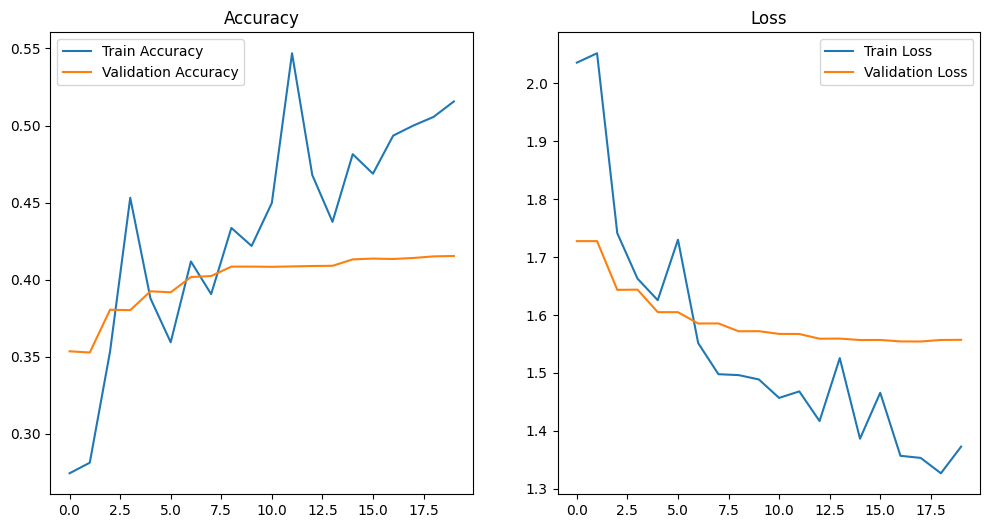

121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 79ms/step - accuracy: 0.3821 - loss: 1.6348
Test Accuracy: 0.4160


In [35]:
from tensorflow.keras.applications import MobileNetV2

train_dir = 'train_augmented'
test_dir = 'test'

IMG_SIZE = (48, 48)
BATCH_SIZE = 64
EPOCHS = 20
NUM_CLASSES = 7

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Загрузка MobileNetV2 (предобученная на ImageNet)
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False

# Добавляем свои слои
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Заменяем Flatten() 
x = BatchNormalization()(x)      # Добавляем BatchNorm
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)              # Уменьшаем Dropout
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Собираем модель
model = Model(inputs=base_model.input, outputs=predictions)

# Компиляция с оптимизатором Adam и learning rate
optimizer = Adam(learning_rate=1e-4)  # Начинаем с малого LR
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Коллбэки
checkpoint = ModelCheckpoint(
    'emotion_mobilenetv2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

# Планировщик learning rate (уменьшаем LR при плато)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=1e-6
)

# Обучение
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.savefig('training_history_mobilenetv2.png')
plt.show()

test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

Время обучения значительно сократилось по сравнению c VGG16, однако результат лучше MobileNetV2 не продемонстрировала.

Вероятно, проблема заключается в несоответсвии предобученных фильтров. VGG16, MobileNetV2 обучались на крупных объектах 224x224, а мой датасет содержит фото лиц 48x48 и информации на них недостаточно. 

Попробую обучить модель ResNet-18 из коллекции PyTourch с заменой последнего слоя под 7 классов. Буду использовать оптимизатор AdamW и планировщик шага обучения ReduceLROnPlateau для улучшения сходимости.

In [ ]:
class FER2013Dataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Чтение изображения
        image = Image.open(self.image_paths[idx]).convert('L')  # Чёрно-белое изображение
        label = self.labels[idx]
        
        if self.transform:
            # Преобразование в RGB (повторение канала 3 раза)
            image = image.convert('RGB')
            image = self.transform(image)
        
        return image, label

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 632/632 [05:52<00:00,  1.79it/s]


Epoch 1/20, Train Loss: 1.6252, Train Acc: 38.42%, Val Loss: 1.4512, Val Acc: 44.56%
Saved best model with Val Acc: 44.56%


Epoch 2/20: 100%|██████████| 632/632 [05:35<00:00,  1.88it/s]


Epoch 2/20, Train Loss: 1.4892, Train Acc: 43.55%, Val Loss: 1.3861, Val Acc: 47.12%
Saved best model with Val Acc: 47.12%


Epoch 3/20: 100%|██████████| 632/632 [05:52<00:00,  1.79it/s]


Epoch 3/20, Train Loss: 1.4262, Train Acc: 46.43%, Val Loss: 1.3568, Val Acc: 48.21%
Saved best model with Val Acc: 48.21%


Epoch 4/20: 100%|██████████| 632/632 [05:39<00:00,  1.86it/s]


Epoch 4/20, Train Loss: 1.3890, Train Acc: 47.56%, Val Loss: 1.3151, Val Acc: 50.18%
Saved best model with Val Acc: 50.18%


Epoch 5/20: 100%|██████████| 632/632 [05:13<00:00,  2.01it/s]


Epoch 5/20, Train Loss: 1.3501, Train Acc: 48.92%, Val Loss: 1.2777, Val Acc: 51.49%
Saved best model with Val Acc: 51.49%


Epoch 6/20: 100%|██████████| 632/632 [05:10<00:00,  2.03it/s]


Epoch 6/20, Train Loss: 1.3359, Train Acc: 49.43%, Val Loss: 1.2778, Val Acc: 52.24%
Saved best model with Val Acc: 52.24%


Epoch 7/20: 100%|██████████| 632/632 [05:11<00:00,  2.03it/s]


Epoch 7/20, Train Loss: 1.3091, Train Acc: 50.59%, Val Loss: 1.2321, Val Acc: 52.67%
Saved best model with Val Acc: 52.67%


Epoch 8/20: 100%|██████████| 632/632 [05:25<00:00,  1.94it/s]


Epoch 8/20, Train Loss: 1.2846, Train Acc: 51.28%, Val Loss: 1.2366, Val Acc: 53.37%
Saved best model with Val Acc: 53.37%


Epoch 9/20: 100%|██████████| 632/632 [05:24<00:00,  1.95it/s]


Epoch 9/20, Train Loss: 1.2659, Train Acc: 52.17%, Val Loss: 1.2173, Val Acc: 53.79%
Saved best model with Val Acc: 53.79%


Epoch 10/20: 100%|██████████| 632/632 [05:20<00:00,  1.97it/s]


Epoch 10/20, Train Loss: 1.2399, Train Acc: 53.32%, Val Loss: 1.2309, Val Acc: 54.10%
Saved best model with Val Acc: 54.10%


Epoch 11/20: 100%|██████████| 632/632 [05:18<00:00,  1.98it/s]


Epoch 11/20, Train Loss: 1.2316, Train Acc: 53.63%, Val Loss: 1.1875, Val Acc: 55.85%
Saved best model with Val Acc: 55.85%


Epoch 12/20: 100%|██████████| 632/632 [05:28<00:00,  1.92it/s]


Epoch 12/20, Train Loss: 1.2056, Train Acc: 54.94%, Val Loss: 1.1716, Val Acc: 55.93%
Saved best model with Val Acc: 55.93%


Epoch 13/20: 100%|██████████| 632/632 [05:26<00:00,  1.94it/s]


Epoch 13/20, Train Loss: 1.1870, Train Acc: 55.39%, Val Loss: 1.1773, Val Acc: 56.23%
Saved best model with Val Acc: 56.23%


Epoch 14/20: 100%|██████████| 632/632 [05:26<00:00,  1.94it/s]


Epoch 14/20, Train Loss: 1.1735, Train Acc: 55.78%, Val Loss: 1.1637, Val Acc: 56.26%
Saved best model with Val Acc: 56.26%


Epoch 15/20: 100%|██████████| 632/632 [05:14<00:00,  2.01it/s]


Epoch 15/20, Train Loss: 1.1462, Train Acc: 56.68%, Val Loss: 1.1690, Val Acc: 56.75%
Saved best model with Val Acc: 56.75%


Epoch 16/20: 100%|██████████| 632/632 [05:26<00:00,  1.94it/s]


Epoch 16/20, Train Loss: 1.1268, Train Acc: 57.87%, Val Loss: 1.1802, Val Acc: 56.41%


Epoch 17/20: 100%|██████████| 632/632 [05:23<00:00,  1.95it/s]


Epoch 17/20, Train Loss: 1.1187, Train Acc: 58.20%, Val Loss: 1.1491, Val Acc: 57.38%
Saved best model with Val Acc: 57.38%


Epoch 18/20: 100%|██████████| 632/632 [05:30<00:00,  1.91it/s]


Epoch 18/20, Train Loss: 1.1044, Train Acc: 59.04%, Val Loss: 1.1558, Val Acc: 56.77%


Epoch 19/20: 100%|██████████| 632/632 [05:54<00:00,  1.78it/s]


Epoch 19/20, Train Loss: 1.0938, Train Acc: 58.80%, Val Loss: 1.1324, Val Acc: 57.89%
Saved best model with Val Acc: 57.89%


Epoch 20/20: 100%|██████████| 632/632 [05:48<00:00,  1.82it/s]


Epoch 20/20, Train Loss: 1.0713, Train Acc: 59.92%, Val Loss: 1.1435, Val Acc: 58.33%
Saved best model with Val Acc: 58.33%


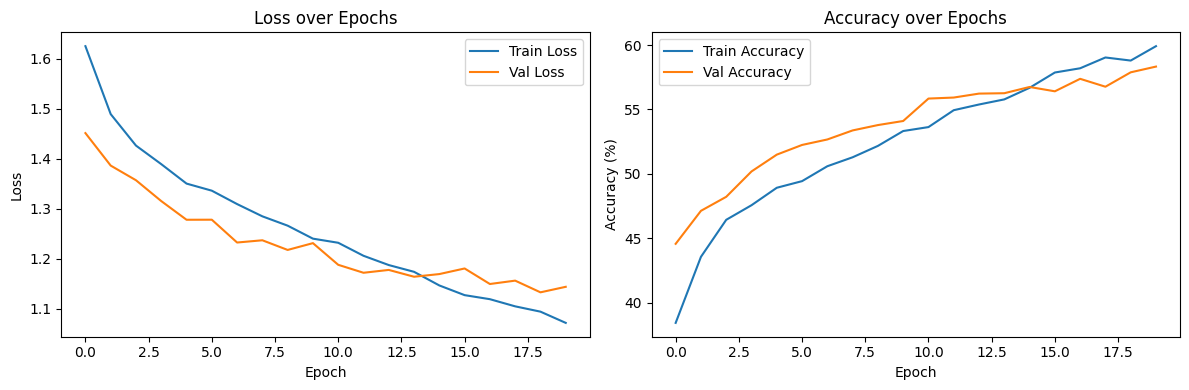

Test Accuracy: 53.08%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cpu")
train_dir = os.path.join('train_augmented')
test_dir = os.path.join('test')

emotion_classes = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
num_classes = len(emotion_classes)

train_image_paths = []
train_labels = []
test_image_paths = []
test_labels = []

for emotion_idx, emotion in enumerate(emotion_classes):
    train_emotion_dir = os.path.join(train_dir, emotion)
    test_emotion_dir = os.path.join(test_dir, emotion)

    for img_name in os.listdir(train_emotion_dir):
        train_image_paths.append(os.path.join(train_emotion_dir, img_name))
        train_labels.append(emotion_idx)

    for img_name in os.listdir(test_emotion_dir):
        test_image_paths.append(os.path.join(test_emotion_dir, img_name))
        test_labels.append(emotion_idx)

train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42
)

# преобразования изображений для единообразия
train_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])  # ImageNet
])

val_test_transforms = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.485, 0.485], std=[0.229, 0.229, 0.229])
])

train_dataset = FER2013Dataset(train_paths, train_labels, transform=train_transforms)
val_dataset = FER2013Dataset(val_paths, val_labels, transform=val_test_transforms)
test_dataset = FER2013Dataset(test_image_paths, test_labels, transform=val_test_transforms)

# 5. Вычисление весов классов для учёта дисбаланса
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (num_classes * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Используем WeightedRandomSampler для балансировки классов
sample_weights = [class_weights[label] for label in train_labels]
sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

model = models.resnet18(pretrained=True)

# Замораживаем все слои, кроме последнего
for param in model.parameters():
    param.requires_grad = False

# Заменяем последний слой под нашу задачу
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

# Размораживаем последние слои для тонкой настройки
for param in model.layer4.parameters():
    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

# 8. Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# 9. Функция для обучения и валидации
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25):
    best_val_acc = 0.0
    best_model_path = 'best_model_test.pth'
    
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    
    for epoch in range(num_epochs):
        # Обучение
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        # Валидация
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        
        # Обновление шага обучения
        scheduler.step(val_loss)
        
        # Сохранение лучшей модели
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with Val Acc: {best_val_acc:.2f}%")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

# 10. Обучение модели
num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)

# 11. Визуализация результатов
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy over Epochs')

plt.tight_layout()
plt.show()

# 12. Оценка на тестовой выборке
model.load_state_dict(torch.load('best_model_test.pth'))
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Результат гораздо лучше. Незначительное переобучение начинается приблизительно на 14 эпохе и точность на валидационной выборке приближается к 60%. Однако это кажется недостаточным. Предобученные модели не очень хорошо работают с черно-белыми изображениями, поэтому в дальнейшем продолжу обучать с нуля.

Попробую модифицировать датасет, сделаем акцент на признаке, показавшем наибольшую значимость в feature importance - LBP (текстура кожи на фото)

Создадим функцию enhance_skin_texture которая с помощью комбинации методов обработки изображений выделит текстуру кожи. 

- С помощью размытия сгладим изображение, убрав мелкие шумы
- Увеличим резкость - вычтем размытую версию из оригинала с весами 1.5 и -0.5 (формула: sharpened = 1.5*gray - 0.5*blurred).
- Применим пдаптивное выравнивание гистограммы, что должно улучшить контраст в локальных областях, избегая переосветления/затемнения.

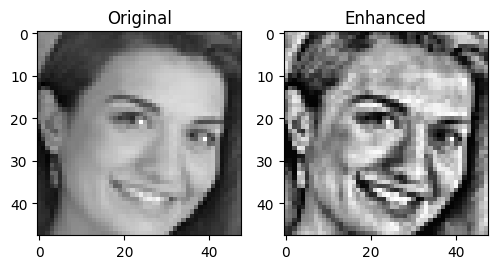

In [54]:
def enhance_skin_texture(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (0, 0), 3)
    sharpened = cv2.addWeighted(gray, 1.5, blurred, -0.5, 0)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    return clahe.apply(sharpened)

image = cv2.imread('train/happy/Training_87867.jpg')

enhanced = enhance_skin_texture(image)

plt.figure(figsize=(10, 5))
plt.subplot(141); plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.title('Original')
plt.subplot(142); plt.imshow(enhanced, cmap='gray'); plt.title('Enhanced')
plt.tight_layout()
plt.show()

На двух изображениях видно, как фильтр сильно выделяет и подчеркивает ключевые детали - складки, морщинки на лице, хакарктерные для той или иной эмоции, что должно сыграть какую-то роль в обучении. 

Обучим простую модель с фильтром.

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 67s 41ms/step - accuracy: 0.3306 - loss: 1.7261 - precision: 0.6457 - recall: 0.0808 - val_accuracy: 0.4474 - val_loss: 1.4492 - val_precision: 0.7055 - val_recall: 0.2395 - learning_rate: 0.0010
Epoch 2/20
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 66s 42ms/step - accuracy: 0.4938 - loss: 1.3440 - precision: 0.7521 - recall: 0.2709 - val_accuracy: 0.4748 - val_loss: 1.3824 - val_precision: 0.7321 - val_recall: 0.2653 - learning_rate: 0.0010
Epoch 3/20
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 65s 41ms/step - accuracy: 0.5497 - loss: 1.2072 - precision: 0.7722 - recall: 0.3458 - val_accuracy: 0.4801 - val_loss: 1.4015 - val_precision: 0.6734 - val_recall: 0.3179 - learning_rate: 0.0010
Epoch 4/20
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 61s 39ms/step - accuracy: 0.5998 - loss: 1.0874 - precision: 0.7855 - recall: 0.4171 - val_accuracy: 0.4962 - val_loss: 1.3733 - val_precision: 0.6653 - val_recall: 0.3385 - learning_rate: 0.0010
Epoch 5/20
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 61s 39

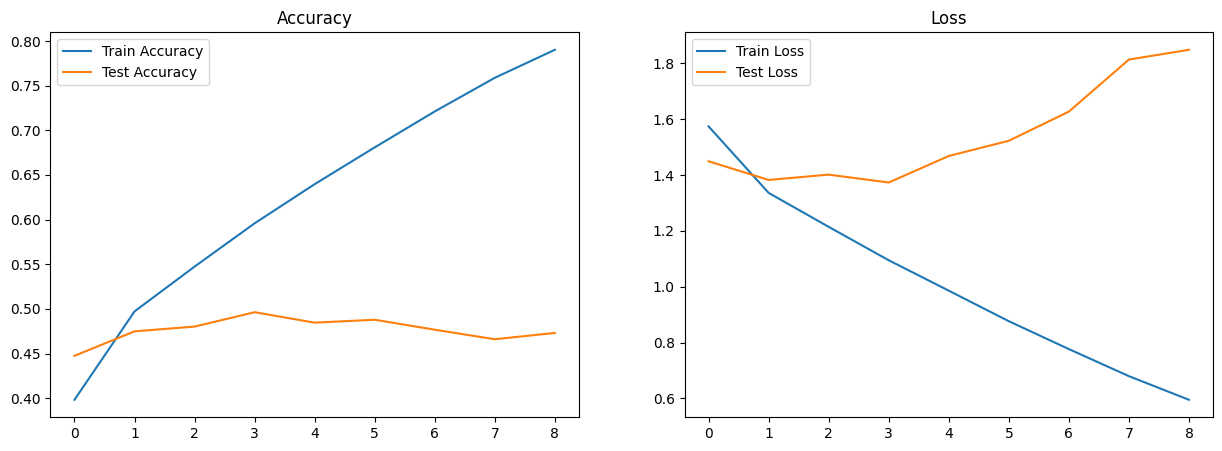

241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.36      0.40      0.38       958
     disgust       0.74      0.70      0.72       637
        fear       0.42      0.18      0.25      1024
       happy       0.59      0.73      0.65      1774
     neutral       0.49      0.39      0.43      1233
         sad       0.33      0.40      0.36      1247
    surprise       0.60      0.65      0.63       831

    accuracy                           0.50      7704
   macro avg       0.50      0.49      0.49      7704
weighted avg       0.49      0.50      0.48      7704



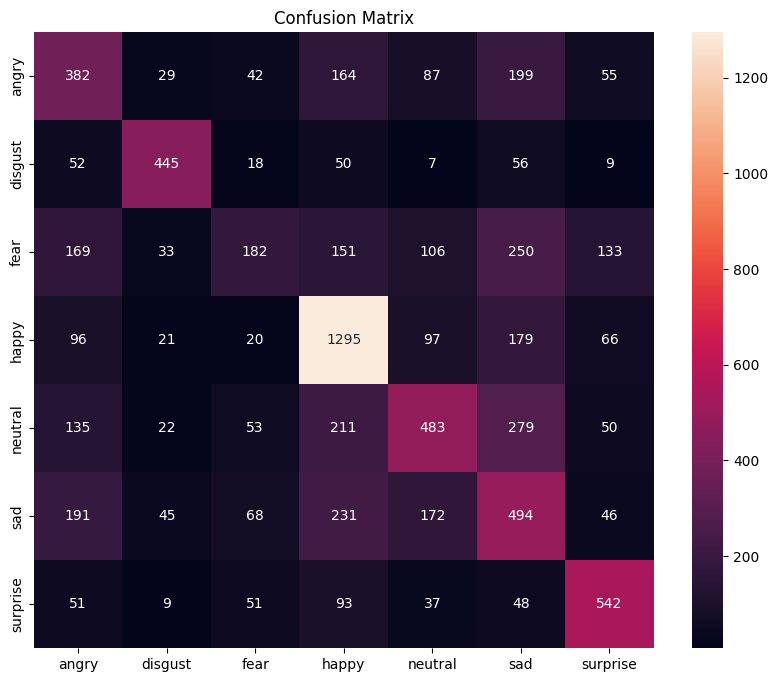

In [ ]:
train_path = "train_augmented"
test_path = "test"

def load_images_from_folder(folder):
    images = []
    labels = []
    categories = sorted(os.listdir(folder))
    
    for category in categories:
        category_path = os.path.join(folder, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                blurred = cv2.GaussianBlur(gray, (0, 0), 3)
                sharpened = sharpened = cv2.addWeighted(gray, 1.2, blurred, -0.2, 0)
                clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
                enhanced = clahe.apply(sharpened)
                enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
                
                images.append(enhanced_rgb)
                labels.append(category)
    
    return np.array(images), np.array(labels)

X_train, y_train = load_images_from_folder(train_path)
X_test, y_test = load_images_from_folder(test_path)

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)
y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)
class_names = le.classes_

input_shape = X_train.shape[1:]
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    EarlyStopping(patience=5,restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=5)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('Loss')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_int, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_matrix(y_test_int, y_pred_classes),
    annot=True, fmt='d',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix')
plt.show()

В результате получаем очень сильное переобучение. На тестовых данных модель демонстрирует высокую точность 80%, однако с фото, необрабоатнными фильтрами она не справляется. Для борьбы с переобучением, будем применять фильтр к 40% фото, чтобы модель сильно не привыкала, но при этом запоминала ключевые особенности текстуры для каждой эмоции

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.1965 - loss: 2.0083 - precision: 0.4369 - recall: 0.0279

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 147s 91ms/step - accuracy: 0.1965 - loss: 2.0081 - precision: 0.4371 - recall: 0.0279 - val_accuracy: 0.3549 - val_loss: 1.7080 - val_precision: 0.7377 - val_recall: 0.0683 - learning_rate: 5.0000e-04
Epoch 2/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3053 - loss: 1.7438 - precision: 0.7137 - recall: 0.1051

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.3053 - loss: 1.7438 - precision: 0.7137 - recall: 0.1051 - val_accuracy: 0.4311 - val_loss: 1.5381 - val_precision: 0.8348 - val_recall: 0.1377 - learning_rate: 5.0000e-04
Epoch 3/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.3479 - loss: 1.6592 - precision: 0.7468 - recall: 0.1420 - val_accuracy: 0.2840 - val_loss: 2.5626 - val_precision: 0.3118 - val_recall: 0.1739 - learning_rate: 5.0000e-04
Epoch 4/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.3779 - loss: 1.5965 - precision: 0.7470 - recall: 0.1684 - val_accuracy: 0.3737 - val_loss: 1.6162 - val_precision: 0.8011 - val_recall: 0.1271 - learning_rate: 5.0000e-04
Epoch 5/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.4016 - loss: 1.5453 - precision: 0.7751 - recall: 0.1895

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - accuracy: 0.4016 - loss: 1.5453 - precision: 0.7751 - recall: 0.1895 - val_accuracy: 0.4663 - val_loss: 1.4369 - val_precision: 0.8286 - val_recall: 0.2008 - learning_rate: 5.0000e-04
Epoch 6/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.4169 - loss: 1.5084 - precision: 0.7670 - recall: 0.2072 - val_accuracy: 0.3753 - val_loss: 1.8501 - val_precision: 0.5499 - val_recall: 0.1880 - learning_rate: 5.0000e-04
Epoch 7/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 147s 93ms/step - accuracy: 0.4321 - loss: 1.4642 - precision: 0.7745 - recall: 0.2214 - val_accuracy: 0.4548 - val_loss: 1.4514 - val_precision: 0.7025 - val_recall: 0.2565 - learning_rate: 5.0000e-04
Epoch 8/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4456 - loss: 1.4250 - precision: 0.7848 - recall: 0.2375

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 149s 94ms/step - accuracy: 0.4456 - loss: 1.4250 - precision: 0.7847 - recall: 0.2375 - val_accuracy: 0.4734 - val_loss: 1.4962 - val_precision: 0.6904 - val_recall: 0.2727 - learning_rate: 5.0000e-04
Epoch 9/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.4606 - loss: 1.4023 - precision: 0.7821 - recall: 0.2448

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 149s 94ms/step - accuracy: 0.4606 - loss: 1.4023 - precision: 0.7821 - recall: 0.2448 - val_accuracy: 0.5106 - val_loss: 1.3132 - val_precision: 0.7780 - val_recall: 0.2852 - learning_rate: 5.0000e-04
Epoch 10/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - accuracy: 0.4699 - loss: 1.3639 - precision: 0.7892 - recall: 0.2659 - val_accuracy: 0.4926 - val_loss: 1.3473 - val_precision: 0.8186 - val_recall: 0.2531 - learning_rate: 5.0000e-04
Epoch 11/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4777 - loss: 1.3472 - precision: 0.7899 - recall: 0.2708

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.4777 - loss: 1.3472 - precision: 0.7899 - recall: 0.2708 - val_accuracy: 0.5238 - val_loss: 1.2770 - val_precision: 0.7912 - val_recall: 0.3021 - learning_rate: 5.0000e-04
Epoch 12/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 148s 94ms/step - accuracy: 0.4904 - loss: 1.3160 - precision: 0.7866 - recall: 0.2855 - val_accuracy: 0.5036 - val_loss: 1.3380 - val_precision: 0.7750 - val_recall: 0.2857 - learning_rate: 5.0000e-04
Epoch 13/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 143s 90ms/step - accuracy: 0.4927 - loss: 1.2988 - precision: 0.7927 - recall: 0.2925 - val_accuracy: 0.5022 - val_loss: 1.3561 - val_precision: 0.7285 - val_recall: 0.3211 - learning_rate: 5.0000e-04
Epoch 14/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 155s 98ms/step - accuracy: 0.5017 - loss: 1.2854 - precision: 0.7951 - recall: 0.3011 - val_accuracy: 0.5016 - val_loss: 1.3113 - val_precision: 0.7655 - val_recall: 0.2988 - learning_rate: 5.0000e-04
Epoch 15/50
1579/1579 ━━━━━━━━━━━━━━

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.5170 - loss: 1.2439 - precision: 0.7895 - recall: 0.3200 - val_accuracy: 0.5280 - val_loss: 1.2611 - val_precision: 0.8064 - val_recall: 0.2996 - learning_rate: 5.0000e-04
Epoch 17/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - accuracy: 0.5202 - loss: 1.2340 - precision: 0.7966 - recall: 0.3263 - val_accuracy: 0.5271 - val_loss: 1.3215 - val_precision: 0.7657 - val_recall: 0.3318 - learning_rate: 5.0000e-04
Epoch 18/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - accuracy: 0.5305 - loss: 1.2138 - precision: 0.8004 - recall: 0.3395 - val_accuracy: 0.4865 - val_loss: 1.6187 - val_precision: 0.6450 - val_recall: 0.3278 - learning_rate: 5.0000e-04
Epoch 19/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5307 - loss: 1.2076 - precision: 0.8029 - recall: 0.3413

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.5307 - loss: 1.2076 - precision: 0.8029 - recall: 0.3413 - val_accuracy: 0.5386 - val_loss: 1.2487 - val_precision: 0.7465 - val_recall: 0.3567 - learning_rate: 5.0000e-04
Epoch 20/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 223s 141ms/step - accuracy: 0.5387 - loss: 1.1877 - precision: 0.8000 - recall: 0.3542 - val_accuracy: 0.5363 - val_loss: 1.2927 - val_precision: 0.7610 - val_recall: 0.3448 - learning_rate: 5.0000e-04
Epoch 21/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.5458 - loss: 1.1685 - precision: 0.7993 - recall: 0.3616

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 154s 97ms/step - accuracy: 0.5458 - loss: 1.1685 - precision: 0.7993 - recall: 0.3616 - val_accuracy: 0.5483 - val_loss: 1.2223 - val_precision: 0.7737 - val_recall: 0.3488 - learning_rate: 5.0000e-04
Epoch 22/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 151s 95ms/step - accuracy: 0.5516 - loss: 1.1574 - precision: 0.8021 - recall: 0.3686 - val_accuracy: 0.5417 - val_loss: 1.2136 - val_precision: 0.8134 - val_recall: 0.3259 - learning_rate: 5.0000e-04
Epoch 23/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5514 - loss: 1.1513 - precision: 0.8078 - recall: 0.3684

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 147s 93ms/step - accuracy: 0.5514 - loss: 1.1513 - precision: 0.8078 - recall: 0.3684 - val_accuracy: 0.5519 - val_loss: 1.2312 - val_precision: 0.7614 - val_recall: 0.3611 - learning_rate: 5.0000e-04
Epoch 24/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.5580 - loss: 1.1385 - precision: 0.7994 - recall: 0.3767 - val_accuracy: 0.5404 - val_loss: 1.2255 - val_precision: 0.7615 - val_recall: 0.3449 - learning_rate: 5.0000e-04
Epoch 25/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 144s 91ms/step - accuracy: 0.5671 - loss: 1.1148 - precision: 0.8112 - recall: 0.3944 - val_accuracy: 0.5500 - val_loss: 1.2300 - val_precision: 0.7367 - val_recall: 0.3912 - learning_rate: 5.0000e-04
Epoch 26/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.5649 - loss: 1.1162 - precision: 0.7996 - recall: 0.3870 - val_accuracy: 0.5457 - val_loss: 1.2132 - val_precision: 0.7499 - val_recall: 0.3685 - learning_rate: 5.0000e-04
Epoch 27/50
1579/1579 ━━━━━━━━━━━━━━

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.5985 - loss: 1.0352 - precision: 0.8219 - recall: 0.4314 - val_accuracy: 0.5665 - val_loss: 1.1828 - val_precision: 0.7566 - val_recall: 0.4036 - learning_rate: 2.5000e-04
Epoch 33/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.6078 - loss: 1.0176 - precision: 0.8156 - recall: 0.4419 - val_accuracy: 0.5588 - val_loss: 1.1784 - val_precision: 0.7660 - val_recall: 0.3893 - learning_rate: 2.5000e-04
Epoch 34/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 145s 92ms/step - accuracy: 0.6083 - loss: 1.0065 - precision: 0.8224 - recall: 0.4489 - val_accuracy: 0.5628 - val_loss: 1.1768 - val_precision: 0.7577 - val_recall: 0.4006 - learning_rate: 2.5000e-04
Epoch 35/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.6138 - loss: 0.9935 - precision: 0.8218 - recall: 0.4576 - val_accuracy: 0.5607 - val_loss: 1.1866 - val_precision: 0.7505 - val_recall: 0.4011 - learning_rate: 2.5000e-04
Epoch 36/50
1579/1579 ━━━━━━━━━━━━━━

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.6208 - loss: 0.9764 - precision: 0.8242 - recall: 0.4680 - val_accuracy: 0.5683 - val_loss: 1.1658 - val_precision: 0.7667 - val_recall: 0.4028 - learning_rate: 2.5000e-04
Epoch 39/50
1578/1579 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6279 - loss: 0.9611 - precision: 0.8262 - recall: 0.4740

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.6279 - loss: 0.9611 - precision: 0.8262 - recall: 0.4740 - val_accuracy: 0.5706 - val_loss: 1.1763 - val_precision: 0.7568 - val_recall: 0.4161 - learning_rate: 2.5000e-04
Epoch 40/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 143s 91ms/step - accuracy: 0.6250 - loss: 0.9631 - precision: 0.8260 - recall: 0.4743 - val_accuracy: 0.5662 - val_loss: 1.1693 - val_precision: 0.7604 - val_recall: 0.4107 - learning_rate: 2.5000e-04
Epoch 41/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 142s 90ms/step - accuracy: 0.6251 - loss: 0.9633 - precision: 0.8226 - recall: 0.4753 - val_accuracy: 0.5702 - val_loss: 1.1814 - val_precision: 0.7592 - val_recall: 0.4142 - learning_rate: 2.5000e-04
Epoch 42/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 149s 94ms/step - accuracy: 0.6272 - loss: 0.9541 - precision: 0.8280 - recall: 0.4817 - val_accuracy: 0.5704 - val_loss: 1.1669 - val_precision: 0.7585 - val_recall: 0.4150 - learning_rate: 2.5000e-04
Epoch 43/50
1579/1579 ━━━━━━━━━━━━━━

1579/1579 ━━━━━━━━━━━━━━━━━━━━ 149s 94ms/step - accuracy: 0.6415 - loss: 0.9199 - precision: 0.8306 - recall: 0.4962 - val_accuracy: 0.5735 - val_loss: 1.1780 - val_precision: 0.7540 - val_recall: 0.4261 - learning_rate: 1.2500e-04
Epoch 47/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 147s 93ms/step - accuracy: 0.6435 - loss: 0.9178 - precision: 0.8299 - recall: 0.4997 - val_accuracy: 0.5658 - val_loss: 1.1790 - val_precision: 0.7553 - val_recall: 0.4142 - learning_rate: 1.2500e-04
Epoch 48/50
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 148s 94ms/step - accuracy: 0.6421 - loss: 0.9160 - precision: 0.8293 - recall: 0.5022 - val_accuracy: 0.5732 - val_loss: 1.1761 - val_precision: 0.7529 - val_recall: 0.4235 - learning_rate: 1.2500e-04


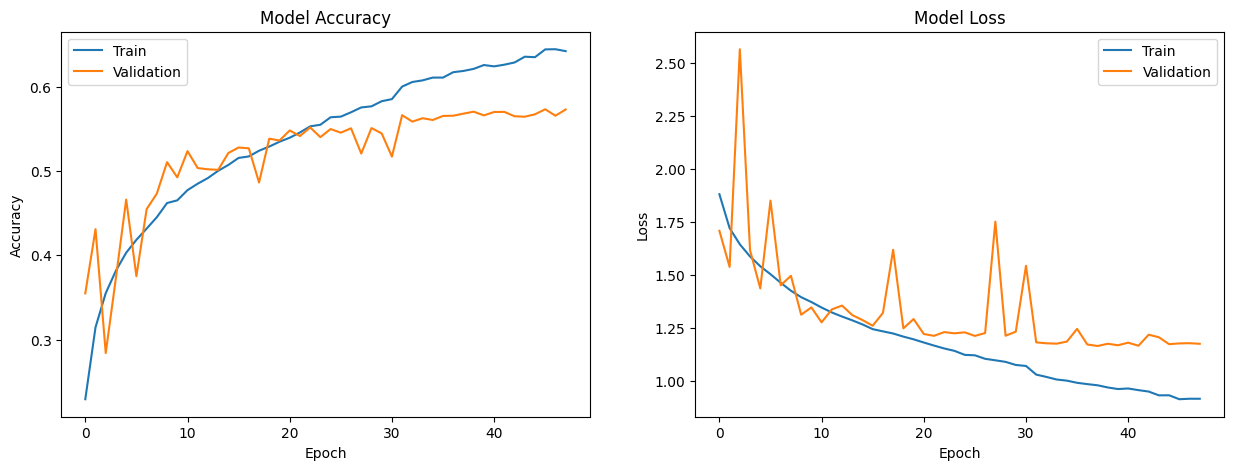

241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Classification Report:
              precision    recall  f1-score   support

       angry       0.43      0.44      0.43       958
     disgust       0.91      0.76      0.83       637
        fear       0.44      0.26      0.32      1024
       happy       0.73      0.76      0.74      1774
     neutral       0.45      0.63      0.52      1233
         sad       0.43      0.37      0.40      1247
    surprise       0.67      0.75      0.71       831

    accuracy                           0.57      7704
   macro avg       0.58      0.57      0.57      7704
weighted avg       0.57      0.57      0.56      7704



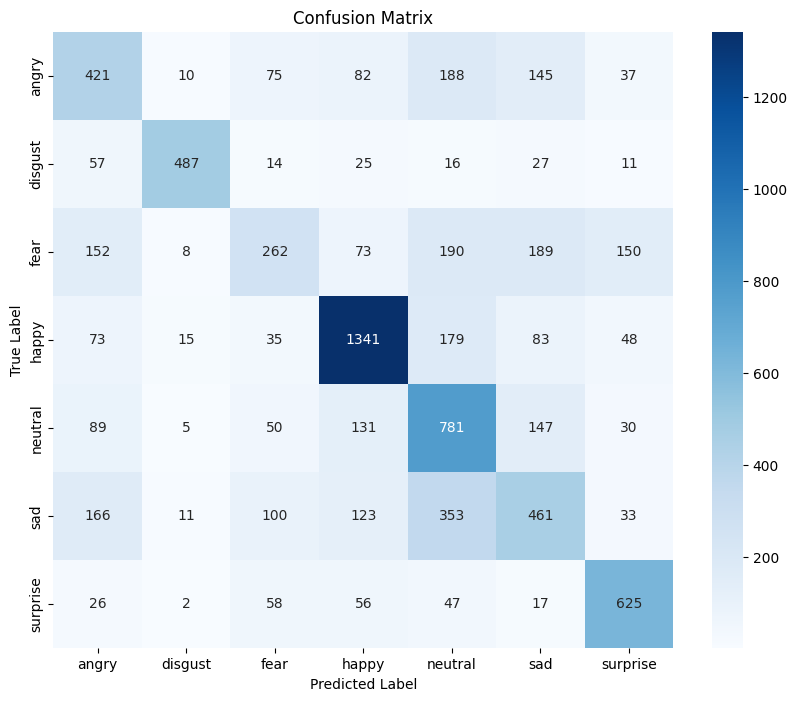

In [ ]:
from sklearn.utils import compute_class_weight


def load_images_from_folder(folder, apply_filter_prob=1):
    images = []
    labels = []
    categories = sorted(os.listdir(folder))
    
    for category in categories:
        category_path = os.path.join(folder, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                # Применяем фильтр только с указанной вероятностью
                if np.random.rand() < apply_filter_prob:
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    blurred = cv2.GaussianBlur(gray, (0, 0), 3)
                    sharpened = sharpened = cv2.addWeighted(gray, 1.2, blurred, -0.2, 0)
                    clahe = cv2.createCLAHE(clipLimit=1.0, tileGridSize=(8, 8))
                    enhanced = clahe.apply(sharpened)
                    img = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
                images.append(img)
                labels.append(category)
    
    return np.array(images), np.array(labels)

train_path = "train_augmented"
test_path = "test"

X_train, y_train = load_images_from_folder(train_path, apply_filter_prob=0.4)  # 30% chance to apply filter
X_test, y_test = load_images_from_folder(test_path, apply_filter_prob=0.0)     # No filter for test

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)
y_train_cat = to_categorical(y_train_int)
y_test_cat = to_categorical(y_test_int)
class_names = le.classes_

class_weights = compute_class_weight('balanced', classes=np.unique(y_train_int), y=y_train_int)
class_weights = dict(enumerate(class_weights))

input_shape = (48, 48, 3)
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=50,
    batch_size=32,
    class_weight=class_weights,  # Балансировка классов
    callbacks=callbacks
)

# 5. Визуализация и оценка
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Оценка модели
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

print("Classification Report:")
print(classification_report(y_test_int, y_pred_classes, target_names=class_names))

plt.figure(figsize=(10,8))
cm = confusion_matrix(y_test_int, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Точность на тренировочных данных быстро растёт в первые 10 эпох, затем рост замедляется.Точность на валидации увеличивается медленнее и стабилизируется после 20 эпох.
Удалось немного сократить переобучение до 10-15% по сравнению с моделью без фильтрации изображений.

Оптимальная версия модели, вероятно, соответствует весам на 20 эпохе. Точность на валидации около 55%, что немного уступает resnet18.

Попробуем поэксперементировать с разными семействами моделей.

In [135]:
train_path = "train_augmented"
test_path = "test_augmented"

X_train, y_train = load_images_from_folder(train_path)
X_test, y_test = load_images_from_folder(test_path)  

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [112]:
def evaluate_model(model, X_test, y_test, model_name):
    """Вычисляет и выводит метрики модели"""
    y_pred = model.predict(X_test)
    print(f"\n{'='*50}\n{model_name}\n{'='*50}")
    print(classification_report(y_test, y_pred, target_names=class_names))

In [168]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier

# Линейная модель
log_reg = LogisticRegression(multi_class='multinomial', max_iter=1000)
log_reg.fit(X_train_scaled, y_train_int)
evaluate_model(log_reg, X_test_scaled, y_test_int, "Logistic Regression")



Logistic Regression
              precision    recall  f1-score   support

       angry       0.23      0.21      0.22      2000
     disgust       0.38      0.43      0.40      2000
        fear       0.22      0.18      0.20      2000
       happy       0.38      0.43      0.40      2000
     neutral       0.26      0.26      0.26      2000
         sad       0.24      0.21      0.22      2000
    surprise       0.43      0.48      0.45      2000

    accuracy                           0.31     14000
   macro avg       0.31      0.31      0.31     14000
weighted avg       0.31      0.31      0.31     14000



Логистическая регрессия демонстрирует низкую производительность с общей точностью 31%. Метрики по классам показывают, что модель плохо справляется с большинством эмоций, особенно с fear (f1-score: 0.20). Модель не подходит для этой задачи.

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

#Деревья

forest = RandomForestClassifier(n_estimators=100, max_depth=8)
forest.fit(X_train_flat, y_train_int)
evaluate_model(forest, X_test_flat, y_test_int, "Random Forest")


Random Forest
              precision    recall  f1-score   support

       angry       0.26      0.08      0.12      2000
     disgust       0.34      0.56      0.43      2000
        fear       0.31      0.02      0.04      2000
       happy       0.30      0.61      0.40      2000
     neutral       0.28      0.27      0.28      2000
         sad       0.25      0.18      0.21      2000
    surprise       0.40      0.52      0.45      2000

    accuracy                           0.32     14000
   macro avg       0.31      0.32      0.27     14000
weighted avg       0.31      0.32      0.27     14000



Random Forest показывает чуть большую точность (32%) по сравнению с логистической регрессией, но все еще низкую для задачи классификации эмоций. Модель лучше справляется с классами disgust, happy и surprise (f1-score: 0.40–0.45), но крайне плохо распознает fear (f1-score: 0.04). Модель неконкурентоспособна для задач компьютерного зрения.

In [134]:
print("X_train_flat shape:", X_train_flat.shape)
print("y_train_int shape:", y_train_int.shape)
print("X_test_flat shape:", X_test_flat.shape)
print("y_test_int shape:", y_test_int.shape)
print("X shape:", X.shape)  # Например, (58209, 6912)
print("y shape:", y.shape) 

X_train_flat shape: (50505, 6912)
y_train_int shape: (50505,)
X_test_flat shape: (7704, 6912)
y_test_int shape: (14000,)
X shape: (50505, 48, 48)
y shape: (50505,)


In [170]:
from catboost import CatBoostClassifier

#Градиентный бустинг

catboost = CatBoostClassifier(iterations=150, depth=5, learning_rate=0.1, verbose=0)
catboost.fit(X_train_flat, y_train_int)
evaluate_model(catboost, X_test_flat, y_test_int, "CatBoost")


CatBoost
              precision    recall  f1-score   support

       angry       0.27      0.16      0.20      2000
     disgust       0.39      0.58      0.47      2000
        fear       0.22      0.06      0.09      2000
       happy       0.40      0.57      0.47      2000
     neutral       0.32      0.35      0.34      2000
         sad       0.28      0.25      0.27      2000
    surprise       0.44      0.56      0.50      2000

    accuracy                           0.36     14000
   macro avg       0.33      0.36      0.33     14000
weighted avg       0.33      0.36      0.33     14000



CatBoost показывает лучшую производительность среди классических моделей с точностью 36%. Это связано с тем, что CatBoost эффективно работает с категориальными и числовыми признаками, автоматически обрабатывает несбалансированность и лучше справляется с нелинейными зависимостями. Классы surprise, disgust и happy имеют более высокие метрики (f1-score: 0.47–0.50), но fear остается проблемным (f1-score: 0.09). Но с глубокими нейронными сетями он не может конкурировать.

In [145]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [ ]:
class AlbumentationsImageDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.data = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data.samples[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

train_transform = A.Compose([
    A.Resize(64, 64),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.CoarseDropout(p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(64, 64),
    A.Normalize(),
    ToTensorV2()
])

# Загрузчики данных
train_dataset = AlbumentationsImageDataset("train_augmented", transform=train_transform)
val_dataset = AlbumentationsImageDataset("test", transform=val_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)

# Устройство
device = torch.device('cpu')

In [ ]:
#Предобученная нейронная сеть

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 7)  # 7 классов
model.to(device)

# Определение функции потерь, оптимизатора и планировщика
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                               steps_per_epoch=len(train_loader), epochs=25)

def train(model, train_loader, val_loader, epochs):
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        train_preds, train_targets = [], []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()

            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            train_preds.extend(pred)
            train_targets.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_loader)
        train_acc = accuracy_score(train_targets, train_preds) * 100
        train_losses.append(avg_loss)
        train_accuracies.append(train_acc)

        # Оценка на валидационной выборке
        val_acc = evaluate(model, val_loader, return_report=False)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss = {avg_loss:.4f}, Train Acc = {train_acc:.2f}%, Val Acc = {val_acc:.2f}%")

    # Полный отчет метрик после завершения обучения
    val_report = evaluate(model, val_loader, return_report=True)
    print(f"\n{'='*50}\nResNet18\n{'='*50}")
    print(val_report)

    return train_losses, train_accuracies, val_accuracies

# Функция оценки
def evaluate(model, dataloader, return_report=False):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            pred = torch.argmax(outputs, dim=1).cpu().numpy()
            preds.extend(pred)
            targets.extend(labels.numpy())
    
    if return_report:
        # Вычисление и форматирование метрик
        report = classification_report(targets, preds, target_names=class_names, digits=2)
        return report
    else:
        # Возвращаем только точность
        acc = accuracy_score(targets, preds) * 100
        return acc

# Запуск обучения
train(model, train_loader, val_loader, epochs=20)

/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/20: 100%|██████████| 790/790 [10:31<00:00,  1.25it/s

Epoch 1: Train Loss = 1.4661, Train Acc = 44.46%, Val Acc = 56.63%


Epoch 2/20: 100%|██████████| 790/790 [10:14<00:00,  1.28it/s]


Epoch 2: Train Loss = 1.1142, Train Acc = 58.09%, Val Acc = 60.25%


Epoch 3/20: 100%|██████████| 790/790 [10:13<00:00,  1.29it/s]


Epoch 3: Train Loss = 1.0139, Train Acc = 61.99%, Val Acc = 62.23%


Epoch 4/20: 100%|██████████| 790/790 [09:07<00:00,  1.44it/s]


Epoch 4: Train Loss = 0.9687, Train Acc = 63.79%, Val Acc = 61.27%


Epoch 5/20: 100%|██████████| 790/790 [09:07<00:00,  1.44it/s]


Epoch 5: Train Loss = 0.9467, Train Acc = 65.03%, Val Acc = 60.75%


Epoch 6/20: 100%|██████████| 790/790 [09:11<00:00,  1.43it/s]


Epoch 6: Train Loss = 0.9244, Train Acc = 65.63%, Val Acc = 63.34%


Epoch 7/20: 100%|██████████| 790/790 [09:11<00:00,  1.43it/s]


Epoch 7: Train Loss = 0.8889, Train Acc = 67.24%, Val Acc = 62.44%


Epoch 8/20: 100%|██████████| 790/790 [09:11<00:00,  1.43it/s]


Epoch 8: Train Loss = 0.8543, Train Acc = 68.58%, Val Acc = 64.69%


Epoch 9/20: 100%|██████████| 790/790 [09:09<00:00,  1.44it/s]


Epoch 9: Train Loss = 0.7962, Train Acc = 70.52%, Val Acc = 62.20%


Epoch 10/20: 100%|██████████| 790/790 [08:58<00:00,  1.47it/s]


Epoch 10: Train Loss = 0.7596, Train Acc = 72.25%, Val Acc = 64.28%


Epoch 11/20: 100%|██████████| 790/790 [10:13<00:00,  1.29it/s]


Epoch 11: Train Loss = 0.6802, Train Acc = 75.19%, Val Acc = 64.59%


Epoch 12/20: 100%|██████████| 790/790 [08:53<00:00,  1.48it/s]


Epoch 12: Train Loss = 0.6051, Train Acc = 77.84%, Val Acc = 66.65%


Epoch 13/20: 100%|██████████| 790/790 [08:42<00:00,  1.51it/s]


Epoch 13: Train Loss = 0.5276, Train Acc = 80.75%, Val Acc = 67.10%


Epoch 14/20: 100%|██████████| 790/790 [08:29<00:00,  1.55it/s]


Epoch 14: Train Loss = 0.4681, Train Acc = 83.17%, Val Acc = 66.36%


Epoch 15/20: 100%|██████████| 790/790 [08:34<00:00,  1.54it/s]


Epoch 15: Train Loss = 0.4114, Train Acc = 85.39%, Val Acc = 67.38%


Epoch 16/20: 100%|██████████| 790/790 [08:54<00:00,  1.48it/s]


Epoch 16: Train Loss = 0.3494, Train Acc = 87.60%, Val Acc = 67.08%


Epoch 17/20: 100%|██████████| 790/790 [08:47<00:00,  1.50it/s]


Epoch 17: Train Loss = 0.2742, Train Acc = 90.31%, Val Acc = 67.33%


Epoch 18/20: 100%|██████████| 790/790 [08:42<00:00,  1.51it/s]


Epoch 18: Train Loss = 0.2303, Train Acc = 91.90%, Val Acc = 67.77%


Epoch 19/20: 100%|██████████| 790/790 [08:29<00:00,  1.55it/s]


Epoch 19: Train Loss = 0.1877, Train Acc = 93.50%, Val Acc = 68.43%


Epoch 20/20: 100%|██████████| 790/790 [08:26<00:00,  1.56it/s]


Epoch 20: Train Loss = 0.1520, Train Acc = 94.82%, Val Acc = 68.26%

ResNet18
              precision    recall  f1-score   support

       angry       0.56      0.57      0.57       958
     disgust       0.96      0.90      0.93       637
        fear       0.55      0.52      0.53      1024
       happy       0.82      0.87      0.84      1774
     neutral       0.63      0.58      0.61      1233
         sad       0.52      0.55      0.53      1247
    surprise       0.80      0.81      0.80       831

    accuracy                           0.68      7704
   macro avg       0.69      0.68      0.69      7704
weighted avg       0.68      0.68      0.68      7704



([1.4661102301712277,
  1.1142189298249499,
  1.0138712852061549,
  0.9687354900414431,
  0.9467384750329996,
  0.9244135846820059,
  0.8888547569890566,
  0.8542872325529026,
  0.7962326339905775,
  0.759568242634399,
  0.6802279949565477,
  0.6050599989257281,
  0.5275740114382551,
  0.46806969508717333,
  0.41141112441126304,
  0.34939981383047525,
  0.27423219738315935,
  0.23028251797526697,
  0.18773557160379767,
  0.15198118784995396],
 [44.46292446292446,
  58.08929808929809,
  61.98990198990199,
  63.78774378774379,
  65.03118503118503,
  65.63310563310564,
  67.24482724482725,
  68.57538857538857,
  70.51777051777051,
  72.25423225423225,
  75.18661518661519,
  77.84377784377784,
  80.75240075240076,
  83.17196317196317,
  85.3935253935254,
  87.5952875952876,
  90.3078903078903,
  91.8998118998119,
  93.50163350163349,
  94.82031482031482],
 [56.63291796469366,
  60.254413291796475,
  62.22741433021807,
  61.2668743509865,
  60.747663551401864,
  63.34371754932503,
  62.4350

ResNet18 показала выдающуюся точность 68% и самые сбалансированные метрики по всем классам (macro avg f1-score: 0.69). Это связано с тем, что ResNet18 как предобученная CNN способная извлекать самые сложные признаки из изображений. Ранее находившийся в убытке класс disgust имеет выдающиеся метрики (f1-score: 0.93). Однако классы fear и sad (f1-score: 0.53) остаются наименее точными, возможно, из-за их визуальной схожести или несбалансированности данных. ResNet18 — наиболее подходящаяя модель для этой задачи, ведь она создана для работы с изображениями. И по сравнению с другими моделями обучалась крайне долго - 190 минут.

Проведен кросс-валидацию, состоящую из 5 фолдов для ResNet18.

Кросс-валидация (cross-validation) - это метод оценки качества моделей машинного обучения, который позволяет оценить, насколько хорошо модель будет работать на новых, ранее не виданных данных. Вместо того, чтобы делить данные на один обучающий и один тестовый набор, кросс-валидация разбивает данные на несколько частей (фолдов), обучает модель на части из них и тестирует на оставшейся части, повторяя этот процесс несколько раз, чтобы каждый фолд побывал в роли тестового. 

In [ ]:
from torch.utils.data import DataLoader, ConcatDataset, Subset
from sklearn.model_selection import KFold

# Объединяем тренировочный и валидационный датасеты для кросс-валидации
full_dataset = ConcatDataset([train_dataset, val_dataset])
# Устанавливаем transform=None, чтобы применить трансформации позже
full_dataset.datasets[0].transform = None
full_dataset.datasets[1].transform = None

device = torch.device('cpu')

n_splits = 5
epochs_per_fold = 4
batch_size = 64

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_val_reports = []
fold_val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(full_dataset)))):
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)

    train_subset.dataset.datasets[0].transform = train_transform
    train_subset.dataset.datasets[1].transform = train_transform
    val_subset.dataset.datasets[0].transform = val_transform
    val_subset.dataset.datasets[1].transform = val_transform

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False, num_workers=0)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 7)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3,
                                                   steps_per_epoch=len(train_loader), epochs=epochs_per_fold)

    def train_one_fold(model, train_loader, val_loader, epochs):
        for epoch in range(epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                scheduler.step()

        val_report, val_acc = evaluate(model, val_loader, return_report=True)
        return val_report, val_acc

    def evaluate(model, dataloader, return_report=False):
        model.eval()
        preds, targets = [], []
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                outputs = model(images)
                pred = torch.argmax(outputs, dim=1).cpu().numpy()
                preds.extend(pred)
                targets.extend(labels.numpy())
        
        if return_report:
            report = classification_report(targets, preds, target_names=class_names, digits=2)
            acc = accuracy_score(targets, preds) * 100
            return report, acc
        else:
            acc = accuracy_score(targets, preds) * 100
            return acc

    val_report, val_acc = train_one_fold(model, train_loader, val_loader, epochs_per_fold)
    fold_val_reports.append(val_report)
    fold_val_accuracies.append(val_acc)

    print(f"\n{'='*50}\nМетрики для Fold {fold+1}\n{'='*50}")
    print(val_report)

print(f"\n{'='*50}\nКросс-валидация для ResNet18\n{'='*50}")
for fold in range(n_splits):
    print(f"Fold {fold+1}: Точность на валидации = {fold_val_accuracies[fold]:.2f}%")
print(f"Средняя валидационная точность: {np.mean(fold_val_accuracies):.2f}%")


Метрики для Fold 1
              precision    recall  f1-score   support

       angry       0.66      0.65      0.65      1672
     disgust       0.95      0.96      0.96      1548
        fear       0.60      0.57      0.58      1629
       happy       0.83      0.86      0.84      1764
     neutral       0.63      0.67      0.65      1666
         sad       0.60      0.56      0.58      1746
    surprise       0.84      0.86      0.85      1617

    accuracy                           0.73     11642
   macro avg       0.73      0.73      0.73     11642
weighted avg       0.73      0.73      0.73     11642



/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Метрики для Fold 2
              precision    recall  f1-score   support

       angry       0.68      0.62      0.65      1660
     disgust       0.97      0.96      0.96      1617
        fear       0.60      0.57      0.59      1625
       happy       0.86      0.82      0.84      1814
     neutral       0.66      0.63      0.64      1725
         sad       0.52      0.64      0.58      1624
    surprise       0.82      0.83      0.83      1577

    accuracy                           0.73     11642
   macro avg       0.73      0.73      0.73     11642
weighted avg       0.73      0.73      0.73     11642



/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Метрики для Fold 3
              precision    recall  f1-score   support

       angry       0.64      0.65      0.64      1582
     disgust       0.95      0.96      0.95      1570
        fear       0.58      0.59      0.59      1586
       happy       0.86      0.82      0.84      1775
     neutral       0.66      0.68      0.67      1740
         sad       0.58      0.57      0.58      1752
    surprise       0.85      0.84      0.84      1637

    accuracy                           0.73     11642
   macro avg       0.73      0.73      0.73     11642
weighted avg       0.73      0.73      0.73     11642



/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Метрики для Fold 4
              precision    recall  f1-score   support

       angry       0.64      0.64      0.64      1612
     disgust       0.95      0.95      0.95      1538
        fear       0.61      0.53      0.57      1713
       happy       0.84      0.85      0.84      1828
     neutral       0.63      0.67      0.65      1651
         sad       0.57      0.59      0.58      1649
    surprise       0.85      0.84      0.84      1651

    accuracy                           0.72     11642
   macro avg       0.72      0.72      0.72     11642
weighted avg       0.72      0.72      0.72     11642



/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/user/Desktop/face_recognizer/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Метрики для Fold 5
              precision    recall  f1-score   support

       angry       0.67      0.64      0.66      1647
     disgust       0.95      0.96      0.96      1579
        fear       0.58      0.58      0.58      1686
       happy       0.85      0.86      0.85      1808
     neutral       0.64      0.67      0.65      1666
         sad       0.57      0.57      0.57      1691
    surprise       0.85      0.84      0.84      1564

    accuracy                           0.73     11641
   macro avg       0.73      0.73      0.73     11641
weighted avg       0.73      0.73      0.73     11641


Кросс-валидация для ResNet18
Fold 1: Точность на валидации = 72.87%
Fold 2: Точность на валидации = 72.56%
Fold 3: Точность на валидации = 72.89%
Fold 4: Точность на валидации = 72.35%
Fold 5: Точность на валидации = 72.87%
Средняя валидационная точность: 72.71%


Вывод: ResNet18 демонстрирует стабильную производительность с точностью около 72.71% по всем фолдам, с минимальным разбросом (0.54% между минимальной и максимальной точностью). Это указывает на хорошую обобщающую способность модели и отсутствие значительного переобучения или недообучения. Метрики macro avg и weighted avg практически идентичны (0.72–0.73), что говорит о сбалансированности классов в тестовых наборах каждого фолда.

Общий выовод.
В данной работе был исследован датасет для классификации эмоций на фотографиях (7 классов: angry, disgust, fear, happy, neutral, sad, surprise), дополненный аугментированными данными для балансировки классов. 
Проведен анализ признаков, реализован фильтр выделяющий текстуру кожи.

Проводились обучения простых нейросетей, предобученных. Анализ предобученных моделей показал, что их эффективность сильно зависит от схожести целевого датасета с данными, на которых они были изначально обучены.

Были проведенены экперементы с моделиями разных семейств: логистическая регрессия (31%), Random Forest (32%), CatBoost (36%) и предобученная ResNet18.

Последняя модель показала наилучшие результаты и точность в 73%. Возможно, будь датасет более качественным (содержал цветные изображения с более высоким разрешением) мне бы удалось добиться лучшего результата. Однако в таком случае время обучения значительно возрасло.

In [ ]:
import joblib

joblib.dump(model, "resnet18_model.pkl")

['resnet18_model.pkl']
